# Thomas Breydo's Biology Research Project

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline

In [3]:
sns.set(context='talk', style='ticks', font='Times New Roman')
TWO_MIN_COLOR = '#0269A4'  # blue
FIVE_MIN_COLOR = '#FE7C00'  # orange

### Get and split data

In [4]:
KEEP_COLS = ['secs','hr']
TWO_MIN = 2 * 60  # in seconds
THREE_MIN = 3 * 60 
FIVE_MIN = 5 * 60

day1_start = 1544  # in seconds
day2_start = 213
day3_start = 182
day4_start = 645

day1_end = day1_start + TWO_MIN
day2_end = day2_start + FIVE_MIN
day3_end = day3_start + FIVE_MIN
day4_end = day4_start + TWO_MIN

day1 = pd.read_csv('../Raw Data/Day 1: 7-18 to 7-20.csv', usecols=KEEP_COLS, index_col='secs')
day2 = pd.read_csv('../Raw Data/Day 2: 7-07 to 7-12.csv', usecols=KEEP_COLS, index_col='secs')
day3 = pd.read_csv('../Raw Data/Day 3: 8-06 to 8-11.csv', usecols=KEEP_COLS, index_col='secs')
day4 = pd.read_csv('../Raw Data/Day 4: 8-53 to 8-55.csv', usecols=KEEP_COLS, index_col='secs')

In [5]:
# pandas slice includes ends
day1_meditation = day1.loc[day1_start: day1_start + TWO_MIN - 1]
day2_meditation = day2.loc[day2_start: day2_start + FIVE_MIN - 1]
day3_meditation = day3.loc[day3_start: day3_start + FIVE_MIN - 1]
day4_meditation = day4.loc[day4_start: day4_start + TWO_MIN - 1]

# get rid of meditation data
day1_non_meditation = day1.drop(index=range(day1_start, day1_start + TWO_MIN + 1))
day2_non_meditation = day2.drop(index=range(day2_start, day2_start + FIVE_MIN + 1))
day3_non_meditation = day3.drop(index=range(day3_start, day3_start + FIVE_MIN + 1))
day4_non_meditation = day4.drop(index=range(day4_start, day4_start + TWO_MIN + 1))

# exactly 3 min before mediation (-1's ensure we don't include first sec of meditation)
day1_pre_meditation = day1.loc[day1_start - THREE_MIN: day1_start - 1]
day2_pre_meditation = day2.loc[day2_start - THREE_MIN: day2_start - 1]
day3_pre_meditation = day3.loc[day3_start - THREE_MIN: day3_start - 1]
day4_pre_meditation = day4.loc[day4_start - THREE_MIN: day4_start - 1]

# exactly 3 min after  mediation (+1's ensure we don't include last sec of meditation)
day1_post_meditation = day1.loc[day1_end + 1: day1_end + THREE_MIN]
day2_post_meditation = day2.loc[day2_end + 1: day2_end + THREE_MIN]
day3_post_meditation = day3.loc[day3_end + 1: day3_end + THREE_MIN]
day4_post_meditation = day4.loc[day4_end + 1: day4_end + THREE_MIN]

### Reset numbering for meditation data to 0-120 or 0-300 secs.

In [6]:
day1_meditation.reset_index(drop=True, inplace=True)
day2_meditation.reset_index(drop=True, inplace=True)
day3_meditation.reset_index(drop=True, inplace=True)
day4_meditation.reset_index(drop=True, inplace=True)

### Normalize

In [7]:
all_days_pre_meditation = pd.concat([day1_pre_meditation, day2_pre_meditation, 
                                        day3_pre_meditation, day4_pre_meditation])
baseline_std = all_days_pre_meditation.std()
baseline_hr = all_days_pre_meditation.mean()

def normalize(meditation):
    # zero-center, then divide by baseline std
    return (meditation - meditation.mean()) / baseline_std

In [8]:
two_min_meditations = pd.concat([day1_meditation, day4_meditation])
five_min_meditations = pd.concat([day2_meditation, day3_meditation])
two_min_meditations_normalized = normalize(two_min_meditations)
five_min_meditations_normalized = normalize(five_min_meditations)

### Graph!

In [9]:
def graph_meditations(two_min_df, five_min_df):
    fig, axes = plt.subplots(1, 2, figsize=(16, 9), sharey=True, 
                       gridspec_kw={'width_ratios': [2, 5]})

    two_min_ax = axes[0]
    five_min_ax = axes[1]

    sns.lineplot(data=two_min_df, ax=two_min_ax, legend=False, palette=[TWO_MIN_COLOR])
    sns.lineplot(data=five_min_df, ax=five_min_ax, legend=False, palette=[FIVE_MIN_COLOR])
    five_min_ax.axvline(120, ls='--', lw=2, color=FIVE_MIN_COLOR)
    
    for ax in two_min_ax, five_min_ax:
        ax.set_xlabel('Elapsed Time (sec)')
        
    two_min_ax.set_title('Two 2-min meditations')
    five_min_ax.set_title('Two 5-min meditations')
    
    return fig, two_min_ax, five_min_ax

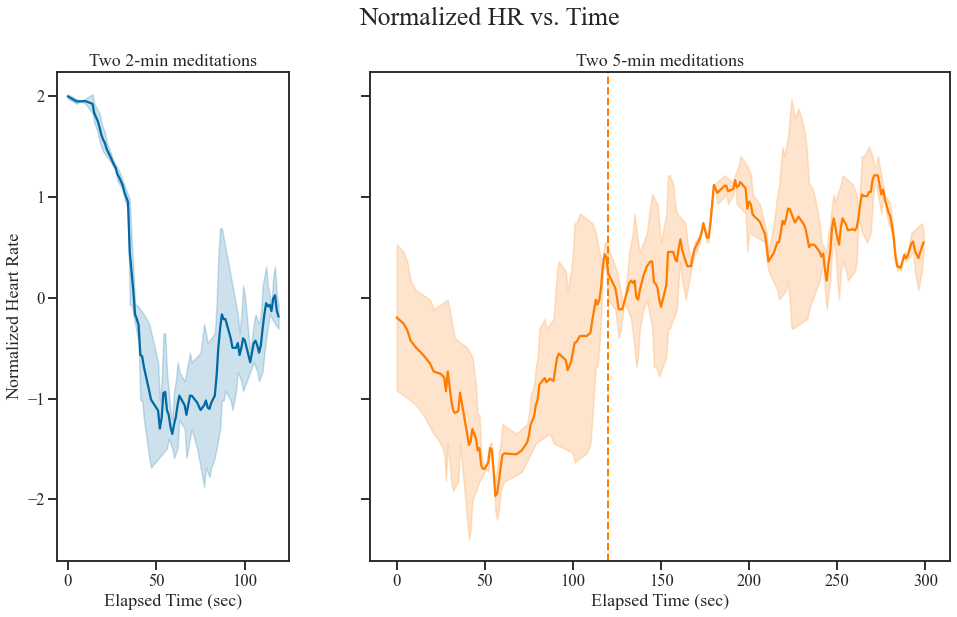

In [10]:
fig, two_min_ax, five_min_ax = graph_meditations(two_min_meditations_normalized,
                                                 five_min_meditations_normalized)

fig.suptitle('Normalized HR vs. Time', fontsize='x-large')
two_min_ax.set_ylabel('Normalized Heart Rate')

fig.savefig('graphs/normalized-no-smoothing')

### Smoothing

In [11]:
# Simple Moving Average

WIN_SIZE = 6

day1_meditation_sma = normalize(day1_meditation).rolling(WIN_SIZE).mean()
day2_meditation_sma = normalize(day2_meditation).rolling(WIN_SIZE).mean()
day3_meditation_sma = normalize(day3_meditation).rolling(WIN_SIZE).mean()
day4_meditation_sma = normalize(day4_meditation).rolling(WIN_SIZE).mean()

two_min_meditations_sma = pd.concat([day1_meditation_sma, day4_meditation_sma])
five_min_meditations_sma = pd.concat([day2_meditation_sma, day3_meditation_sma])

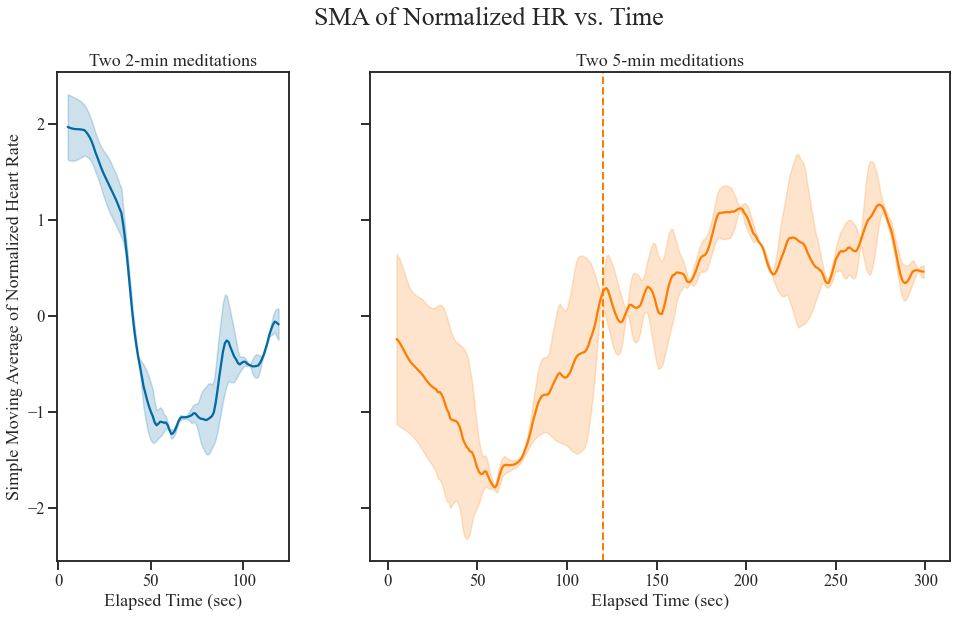

In [12]:
fig, two_min_ax, five_min_ax = graph_meditations(two_min_meditations_sma, 
                                                 five_min_meditations_sma)

fig.suptitle('SMA of Normalized HR vs. Time', fontsize='x-large')
    
two_min_ax.set_ylabel('Simple Moving Average of Normalized Heart Rate')

fig.savefig('graphs/normalized-sma-smoothing')

### Subtract from baseline and show difference line graph.

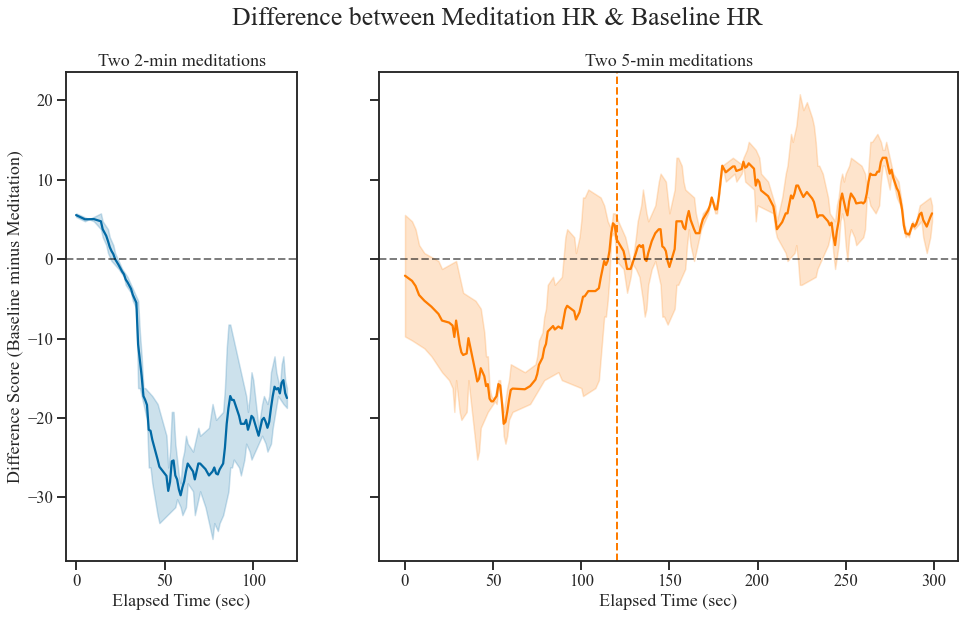

In [13]:
fig, two_min_ax, five_min_ax = graph_meditations(two_min_meditations - baseline_hr, 
                                                 five_min_meditations - baseline_hr)

fig.suptitle('Difference between Meditation HR & Baseline HR', fontsize='x-large')

two_min_ax.set_ylabel('Difference Score (Baseline minus Meditation)')

for ax in two_min_ax, five_min_ax:
    ax.axhline(0, ls='--', lw=2, color='black', alpha=.5)

fig.savefig('graphs/difference-graph')

### Box and whiskers plot of HR before/during/after.

In [14]:
KEYS = ['Pre', 'During', 'Post']
COL_NAME = '/'.join(KEYS)

day1_pre_during_post = pd.concat([day1_pre_meditation, day1_meditation, day1_post_meditation], 
                                 keys=KEYS, names=[COL_NAME])
day2_pre_during_post = pd.concat([day2_pre_meditation, day2_meditation, day2_post_meditation], 
                                 keys=KEYS, names=[COL_NAME])
day3_pre_during_post = pd.concat([day3_pre_meditation, day3_meditation, day3_post_meditation], 
                                 keys=KEYS, names=[COL_NAME])
day4_pre_during_post = pd.concat([day4_pre_meditation, day4_meditation, day4_post_meditation], 
                                 keys=KEYS, names=[COL_NAME])
    
day1_pre_during_post.reset_index(level=0, inplace=True)  # pull out Pre/Post/During information into a col
day2_pre_during_post.reset_index(level=0, inplace=True)  # pull out Pre/Post/During information into a col
day3_pre_during_post.reset_index(level=0, inplace=True)  # pull out Pre/Post/During information into a col
day4_pre_during_post.reset_index(level=0, inplace=True)  # pull out Pre/Post/During information into a col

two_min_pre_during_post = pd.concat([day1_pre_during_post, day4_pre_during_post])
five_min_pre_during_post = pd.concat([day2_pre_during_post, day3_pre_during_post])

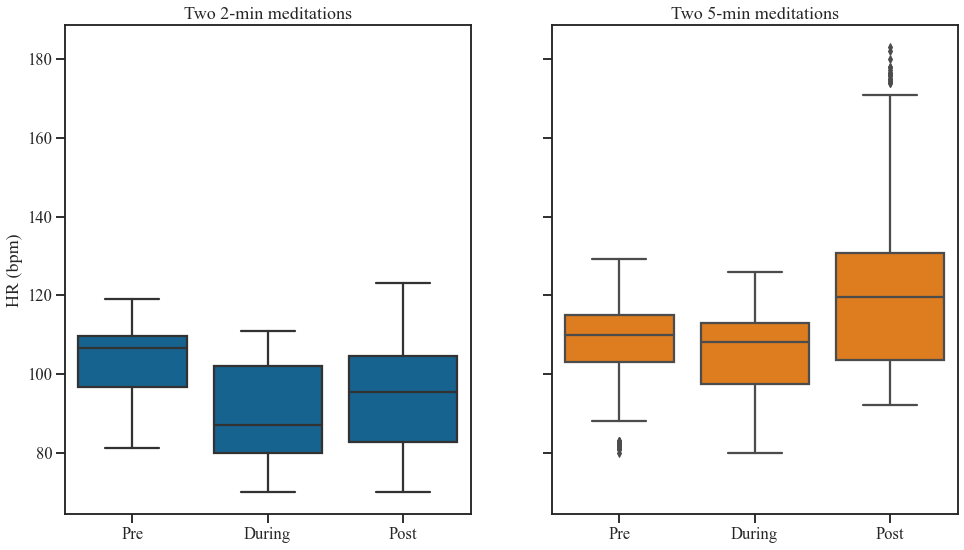

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9), sharey=True)

two_min_ax = axes[0]
five_min_ax = axes[1]

X_COL = 'Pre/During/Post'
Y_COL = 'hr'

sns.boxplot(x=X_COL, y=Y_COL, data=two_min_pre_during_post, ax=two_min_ax, color=TWO_MIN_COLOR)
sns.boxplot(x=X_COL, y=Y_COL, data=five_min_pre_during_post, ax=five_min_ax, color=FIVE_MIN_COLOR)

two_min_ax.set_title('Two 2-min meditations')
five_min_ax.set_title('Two 5-min meditations')

two_min_ax.set_xlabel('')
two_min_ax.set_ylabel('HR (bpm)')
five_min_ax.set_xlabel('')
five_min_ax.set_ylabel('')

fig.savefig('graphs/boxplots')